In [1]:
import pandas as pd

train_data = pd.read_csv(r'''/home/sagar/GitHub-Repos/Real_OR_Not/train.csv''')
test_data = pd.read_csv(r'''/home/sagar/GitHub-Repos/Real_OR_Not/test.csv''')


In [2]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [3]:
train_data['text'].str.isnumeric().any()

False

In [4]:
train_data['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [5]:
train_x = train_data['text'].to_numpy()
y_train = train_data['target'].to_numpy()

In [6]:
test_x = test_data['text'].to_numpy()

In [18]:
## Tokenizing the data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100        # cuts off review after 100 words
max_words = 10000        # Considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)


In [19]:
## Using keras for word-level one-hot encoding

from keras.preprocessing.text import Tokenizer


# # creates a tokenizer, configured to only take into account the 1000 most common words
# tokenizer = Tokenizer(num_words=1000)

# Builds the word index
tokenizer.fit_on_texts(train_x)

# turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(train_x)

# # one-hot binary representation. Vectorization modes other than one-hot encoding are supported by this tokenizer
# one_hot_results = tokenizer.texts_to_matrix(train_x, mode='binary')

# to recover the word index that was computed 
word_index = tokenizer.word_index
print('Found %s unique tokens.'%len(word_index))

Found 22700 unique tokens.


In [20]:

# Builds the word index
tokenizer.fit_on_texts(test_x)

# turns strings into lists of integer indices
sequences_test = tokenizer.texts_to_sequences(test_x)

# # one-hot binary representation. Vectorization modes other than one-hot encoding are supported by this tokenizer
# one_hot_test = tokenizer.texts_to_matrix(test_x, mode='binary')

# to recover the word index that was computed 
word_index = tokenizer.word_index
print('Found %s unique tokens.'%len(word_index))

Found 29319 unique tokens.


In [22]:
# Turns the lists of integers into a 2D integer tensor of shape(samples, maxlen)
from keras import preprocessing
maxlen = 1000
x_train = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)

In [23]:
print(x_train.shape, y_train.shape, x_test.shape)

(7613, 1000) (7613,) (3263, 1000)


In [24]:
from sklearn.model_selection import train_test_split

tr_x, val_x, tr_y, val_y = train_test_split(x_train, y_train, test_size = 0.3, shuffle = True)

In [25]:
## Parsing the GloVe word-embeddings
import os
import numpy as np

glove_dir = r'''/home/sagar/GitHub-Repos/Deep Learning with Python/glove.6B'''

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [26]:
## preparing GloVe word-embeddings matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # words not found in the embedding index will be all zeros

In [12]:
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Embedding, SimpleRNN, LSTM

# model = Sequential()
# model.add(Embedding(10000, 8, input_length=maxlen))
# # model.add(SimpleRNN(32))
# model.add(LSTM(50))
# # model.add(Flatten())


# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# model.summary()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 91,851
Trainable params: 91,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
## defining a model

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 1,030,251
Trainable params: 1,030,251
Non-trainable params: 0
_________________________________________________________________


In [33]:
## loading pretrained word embeddings into the embedding layer

model.layers[0].set_weights([embedding_matrix])
# set trainable attribute to False
model.layers[0].trainable = False

In [ ]:
# history = model.fit(tr_x, tr_y, epochs =10, batch_size=50, validation_split=0.2)


Train on 4263 samples, validate on 1066 samples
Epoch 1/10
4263/4263 [==============================] - 86s 20ms/step - loss: 0.6581 - acc: 0.6068 - val_loss: 0.6083 - val_acc: 0.7045
Epoch 2/10
4263/4263 [==============================] - 84s 20ms/step - loss: 0.5584 - acc: 0.7314 - val_loss: 0.5437 - val_acc: 0.7505
Epoch 3/10
4263/4263 [==============================] - 92s 22ms/step - loss: 0.4841 - acc: 0.7851 - val_loss: 0.5190 - val_acc: 0.7739
Epoch 4/10
2750/4263 [==================>...........] - ETA: 29s - loss: 0.4362 - acc: 0.8011

In [34]:
## training and evaluation

model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])

history = model.fit(tr_x, tr_y, epochs=10, batch_size=50, validation_split=0.2)

# model.save_weights('pre_trained_glove_model.h5')

Train on 4263 samples, validate on 1066 samples
Epoch 1/10
4263/4263 [==============================] - 103s 24ms/step - loss: 0.6483 - acc: 0.6312 - val_loss: 0.6699 - val_acc: 0.5994
Epoch 2/10
4263/4263 [==============================] - 101s 24ms/step - loss: 0.6124 - acc: 0.6716 - val_loss: 0.6098 - val_acc: 0.6764
Epoch 3/10
4263/4263 [==============================] - 101s 24ms/step - loss: 0.5898 - acc: 0.6967 - val_loss: 0.6925 - val_acc: 0.6107
Epoch 4/10
4263/4263 [==============================] - 102s 24ms/step - loss: 0.5678 - acc: 0.7105 - val_loss: 0.5822 - val_acc: 0.7045
Epoch 5/10
4263/4263 [==============================] - 101s 24ms/step - loss: 0.5486 - acc: 0.7253 - val_loss: 0.5728 - val_acc: 0.7195
Epoch 6/10
4263/4263 [==============================] - 97s 23ms/step - loss: 0.5294 - acc: 0.7450 - val_loss: 0.5986 - val_acc: 0.6951
Epoch 7/10
2750/4263 [==================>...........] - ETA: 37s - loss: 0.5129 - acc: 0.7462

KeyboardInterrupt: 

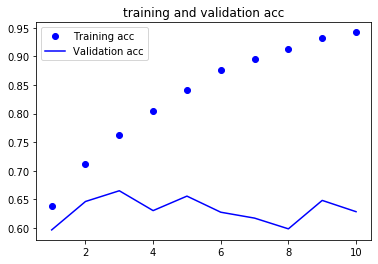

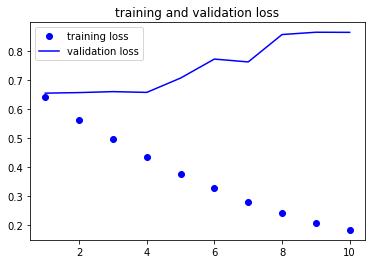

In [31]:
## Plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [17]:
history = model.fit(tr_x, tr_y, epochs =7, batch_size=50, validation_split=0.2)

Train on 4263 samples, validate on 1066 samples
Epoch 1/7
4263/4263 [==============================] - 25s 6ms/step - loss: 0.3120 - acc: 0.8757 - val_loss: 0.4545 - val_acc: 0.8049
Epoch 2/7
4263/4263 [==============================] - 25s 6ms/step - loss: 0.3317 - acc: 0.8590 - val_loss: 0.5132 - val_acc: 0.7842
Epoch 3/7
4263/4263 [==============================] - 25s 6ms/step - loss: 0.2768 - acc: 0.8865 - val_loss: 0.5151 - val_acc: 0.7767
Epoch 4/7
4263/4263 [==============================] - 25s 6ms/step - loss: 0.3321 - acc: 0.8586 - val_loss: 0.5113 - val_acc: 0.7852
Epoch 5/7
4263/4263 [==============================] - 25s 6ms/step - loss: 0.3701 - acc: 0.8337 - val_loss: 0.4572 - val_acc: 0.8077
Epoch 6/7
4263/4263 [==============================] - 26s 6ms/step - loss: 0.2982 - acc: 0.8703 - val_loss: 0.4667 - val_acc: 0.8002
Epoch 7/7
4263/4263 [==============================] - 28s 6ms/step - loss: 0.2666 - acc: 0.8919 - val_loss: 0.4975 - val_acc: 0.8049


In [18]:
model.evaluate(val_x, val_y)

2284/2284 [==============================] - 2s 833us/step


[0.5590561165387911, 0.7802101575138273]

In [19]:
preds = model.predict(x_test)

In [20]:
print(len(test_data['text']), len(preds))

3263 3263


In [21]:
predicts = pd.DataFrame(preds)
predicts = round(predicts)
predicts

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3258,0.0
3259,1.0
3260,1.0
3261,0.0


In [22]:
predicts.to_csv(r'''/home/sagar/GitHub-Repos/Real_OR_Not/submission.csv''')